# Лабораторная работа 3

1) Полносвязная нейронная сеть ( Fully-Connected Neural Network)

2) Нормализация по мини-батчам (Batch normalization)

3) Dropout

4) Сверточные нейронные сети (Convolutional Networks)

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

# Полносвязная нейронная сеть

В данной лабораторной работе необходимо будет реализовать полносвязную нейронную сеть, используя модульный подход. Для каждого  слоя реализации прямого и обратного проходов алгоритма обратного распространения ошибки будут иметь следующий вид:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```



```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

    

In [6]:
from __future__ import print_function
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scripts.classifiers.fc_net import *
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from scripts.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from scripts.solver import Solver
from scripts.classifiers.cnn import *
from scripts.layers import *
from scripts.fast_layers import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Загрузите данные из предыдущей лабораторной работы. 

In [118]:
X, y = load_digits(return_X_y = True)
X = X.reshape(X.shape[0], 1, np.sqrt(X.shape[1]).astype(np.int32), np.sqrt(X.shape[1]).astype(np.int32))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

data = {
    'X_train': X_train,
    'X_test': X_test,
    'X_val': X_val,
    'y_train': y_train,
    'y_test': y_test,
    'y_val': y_val,
}

Training data shape:  (1293, 1, 8, 8)
Training labels shape:  (1293,)
Validation data shape:  (144, 1, 8, 8)
Validation labels shape:  (144,)
Test data shape:  (360, 1, 8, 8)
Test labels shape:  (360,)


Для полносвязного слоя реализуйте прямой проход (метод affine_forward в scripts/layers.py). Протестируйте свою реализацию. 

In [9]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])


print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


Для полносвязного слоя реализуйте обратный проход (метод affine_backward в scripts/layers.py). Протестируйте свою реализацию. 

In [10]:
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


Реализуйте прямой проход для слоя активации ReLU (relu_forward) и протестируйте его.

In [11]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


Реализуйте обратный проход для слоя активации ReLU (relu_backward ) и протестируйте его.

In [42]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


В скрипте /layer_utils.py приведены реализации прямого и обратного проходов для часто используемых комбинаций слоев. Например, за полносвязным слоем часто следует слой активации. Ознакомьтесь с функциями affine_relu_forward и affine_relu_backward, запустите код ниже и убедитесь, что ошибка порядка e-10 или ниже. 

In [43]:
from scripts.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


Реализуйте двухслойную полносвязную сеть - класс TwoLayerNet в scripts/classifiers/fc_net.py . Проверьте свою реализацию, запустив код ниже. 

In [65]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)
    
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


In [61]:
model.params['W1'][:, :64].shape

(3072, 64)

In [74]:
model = TwoLayerNet(input_dim=64, hidden_dim=100, num_classes=10, weight_scale=1e-2, reg=0.00)

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rate = 1e-3
solver = Solver(model, data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1020) loss: 2.300089
(Epoch 0 / 20) train acc: 0.126000; val_acc: 0.097222
(Iteration 11 / 1020) loss: 2.291745
(Iteration 21 / 1020) loss: 2.297203
(Iteration 31 / 1020) loss: 2.290379
(Iteration 41 / 1020) loss: 2.291292
(Iteration 51 / 1020) loss: 2.287987
(Epoch 1 / 20) train acc: 0.238000; val_acc: 0.291667
(Iteration 61 / 1020) loss: 2.295393
(Iteration 71 / 1020) loss: 2.292068
(Iteration 81 / 1020) loss: 2.282785
(Iteration 91 / 1020) loss: 2.272011
(Iteration 101 / 1020) loss: 2.280515
(Epoch 2 / 20) train acc: 0.342000; val_acc: 0.375000
(Iteration 111 / 1020) loss: 2.293546
(Iteration 121 / 1020) loss: 2.279957
(Iteration 131 / 1020) loss: 2.258197
(Iteration 141 / 1020) loss: 2.253761
(Iteration 151 / 1020) loss: 2.248021
(Epoch 3 / 20) train acc: 0.366000; val_acc: 0.423611
(Iteration 161 / 1020) loss: 2.220451
(Iteration 171 / 1020) loss: 2.232846
(Iteration 181 / 1020) loss: 2.229027
(Iteration 191 / 1020) loss: 2.237919
(Iteration 201 / 1020) loss: 2.2521

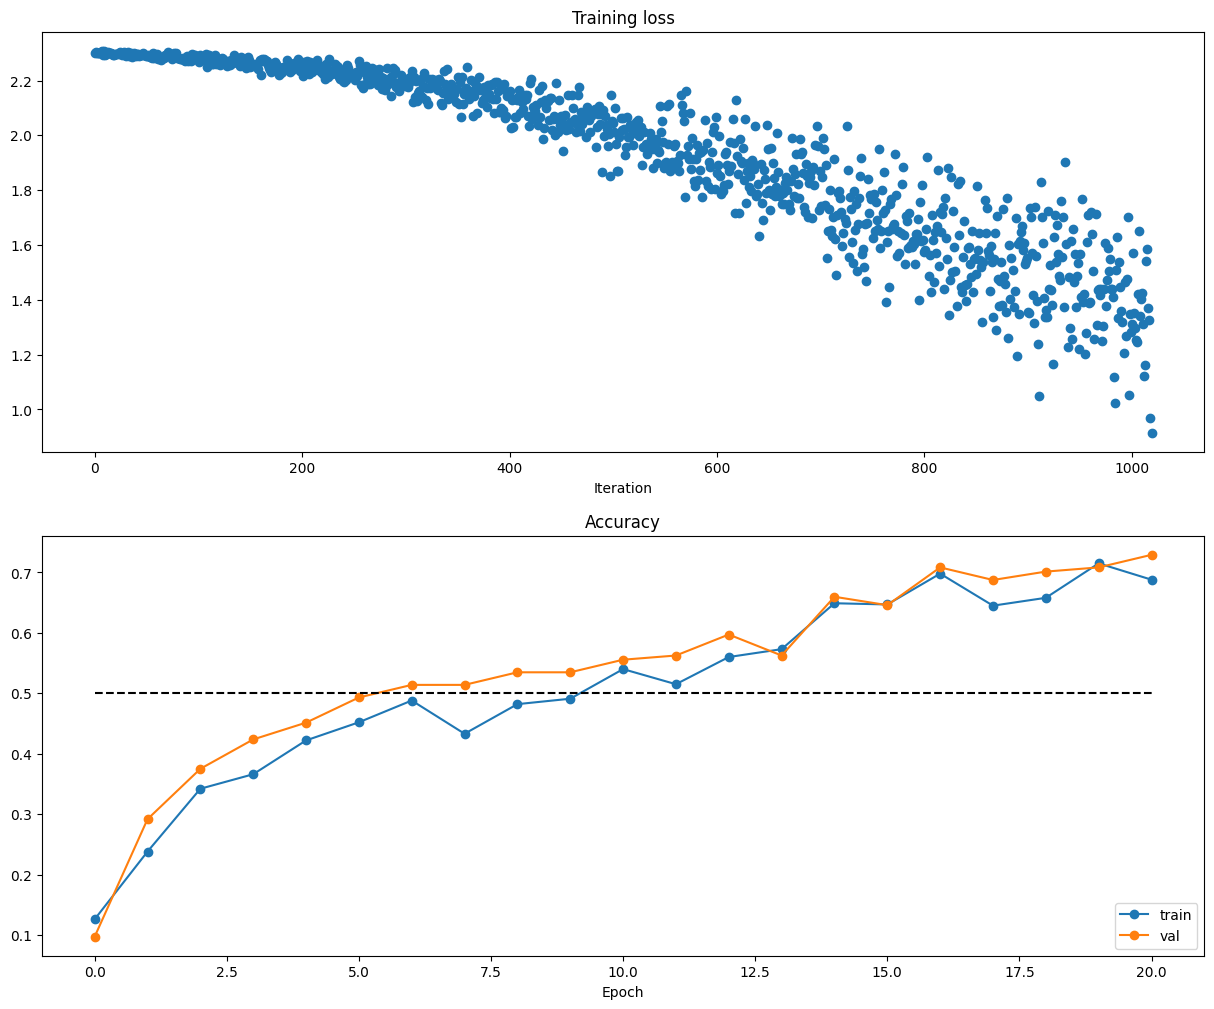

In [75]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

Теперь реализуйте полносвязную сеть с произвольным числом скрытых слоев. Ознакомьтесь с классом FullyConnectedNet в scripts/classifiers/fc_net.py . Реализуйте инициализацию, прямой и обратный проходы.

In [76]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C, reg=reg, weight_scale=5e-2, dtype=np.float64)
    
    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
    
    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.90e-09
W2 relative error: 6.87e-08
W3 relative error: 2.13e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.57e-10


Попробуйте добиться эффекта переобучения на небольшом наборе изображений (например, 50). Используйте трехслойную сеть со 100 нейронами на каждом скрытом слое. Попробуйте переобучить сеть, достигнув 100 % accuracy за 20 эпох. Для этого поэкспериментируйте с параметрами weight_scale и learning_rate. 

(Iteration 1 / 40) loss: 3.865658
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.173611
(Epoch 1 / 20) train acc: 0.180000; val_acc: 0.090278
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.229167
(Epoch 3 / 20) train acc: 0.400000; val_acc: 0.291667
(Epoch 4 / 20) train acc: 0.460000; val_acc: 0.395833
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.444444
(Iteration 11 / 40) loss: 1.051756
(Epoch 6 / 20) train acc: 0.680000; val_acc: 0.423611
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.618056
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.638889
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.590278
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.611111
(Iteration 21 / 40) loss: 0.439805
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.666667
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.673611
(Epoch 13 / 20) train acc: 0.920000; val_acc: 0.631944
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.694444
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.680556
(Iteration 31 / 40) loss: 

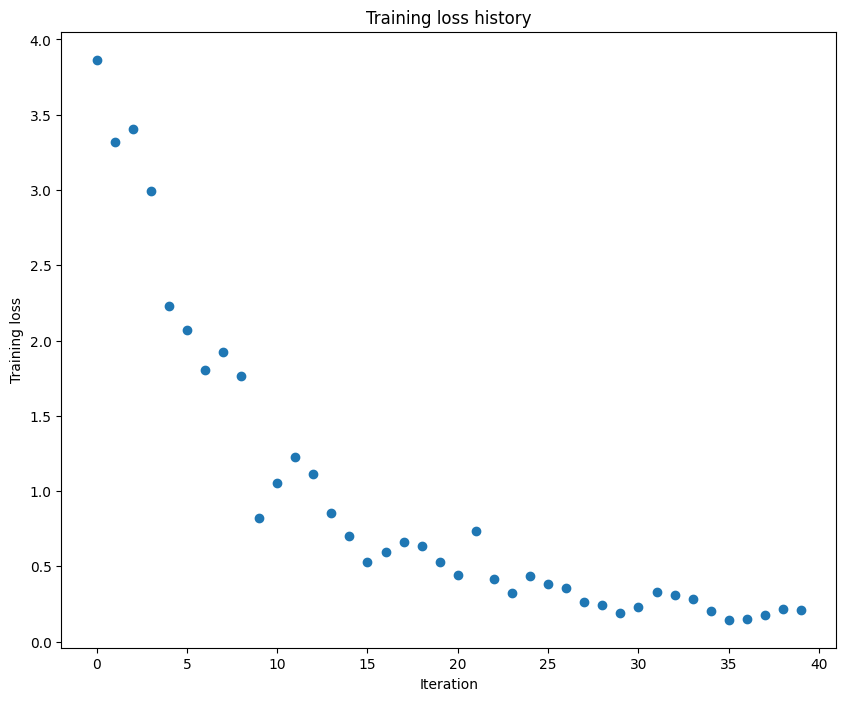

In [78]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
learning_rates = [1e-2]
weight_scales = [1e-1]
best_acc = 0.0
best_losses = []
for lr in learning_rates:
    for ws in weight_scales:
        model = FullyConnectedNet([100, 100], input_dim=8*8, weight_scale=ws, dtype=np.float64)

        solver = Solver(model, small_data,
                        print_every=10, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': lr,
                        }
                 )
        solver.train()
        if solver.train_acc_history[-1] > best_acc:
            best_losses = solver.loss_history
            

plt.plot(best_losses, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Повторите эксперимент, описанный выше, для пятислойной сети.

(Iteration 1 / 40) loss: 86.178889
(Epoch 0 / 20) train acc: 0.080000; val_acc: 0.138889
(Epoch 1 / 20) train acc: 0.140000; val_acc: 0.118056
(Epoch 2 / 20) train acc: 0.120000; val_acc: 0.097222
(Epoch 3 / 20) train acc: 0.320000; val_acc: 0.166667
(Epoch 4 / 20) train acc: 0.320000; val_acc: 0.111111
(Epoch 5 / 20) train acc: 0.420000; val_acc: 0.222222
(Iteration 11 / 40) loss: 3.848691
(Epoch 6 / 20) train acc: 0.360000; val_acc: 0.208333
(Epoch 7 / 20) train acc: 0.580000; val_acc: 0.277778
(Epoch 8 / 20) train acc: 0.520000; val_acc: 0.312500
(Epoch 9 / 20) train acc: 0.780000; val_acc: 0.354167
(Epoch 10 / 20) train acc: 0.880000; val_acc: 0.437500
(Iteration 21 / 40) loss: 0.670185
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.430556
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.472222
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.486111
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.472222
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.493056
(Iteration 31 / 40) loss:

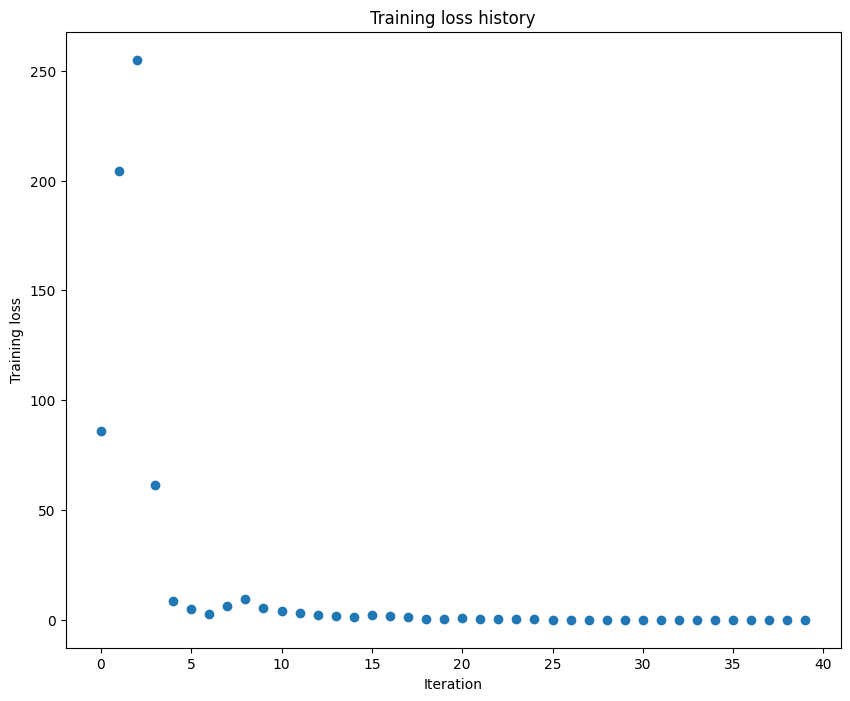

In [81]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scales = [2e-1]
learning_rates = [1e-2]

best_acc = 0.0
best_losses = []
for lr in learning_rates:
    for ws in weight_scales:
        model = FullyConnectedNet([100, 100, 100, 100], input_dim=8*8, weight_scale=ws, dtype=np.float64)
        
        solver = Solver(model, small_data,
                        print_every=10, num_epochs=20, batch_size=25,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': lr,
                        }
                 )
        solver.train()
        if solver.train_acc_history[-1] > best_acc:
            best_losses = solver.loss_history

plt.plot(best_losses, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Сделайте выводы по проведенному эксперименту. 

5 слойная сеть переобучается сильнее, чем 3-х слойная ввиду наличия большего числа нейронов. Результаты на валидационной выборке хуже

Ранее обновление весов проходило по правилу SGD. Теперь попробуйте реализовать стохастический градиентный спуск с импульсом (SGD+momentum). http://cs231n.github.io/neural-networks-3/#sgd Реализуйте sgd_momentum в scripts/optim.py  и запустите проверку. 

In [82]:
from scripts.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Сравните результаты обучения шестислойной сети, обученной классическим градиентным спуском и адаптивным алгоритмом с импульсом. Какой алгоритм сходится быстрее.

running with  sgd
(Iteration 1 / 60) loss: 2.299671
(Epoch 0 / 5) train acc: 0.111000; val_acc: 0.111111
(Iteration 11 / 60) loss: 2.301239
(Epoch 1 / 5) train acc: 0.102000; val_acc: 0.118056
(Iteration 21 / 60) loss: 2.300359
(Epoch 2 / 5) train acc: 0.111000; val_acc: 0.118056
(Iteration 31 / 60) loss: 2.299751
(Epoch 3 / 5) train acc: 0.123000; val_acc: 0.118056
(Iteration 41 / 60) loss: 2.301142
(Epoch 4 / 5) train acc: 0.094000; val_acc: 0.118056
(Iteration 51 / 60) loss: 2.301361
(Epoch 5 / 5) train acc: 0.117000; val_acc: 0.125000

running with  sgd_momentum
(Iteration 1 / 60) loss: 2.304391
(Epoch 0 / 5) train acc: 0.074000; val_acc: 0.041667
(Iteration 11 / 60) loss: 2.301893
(Epoch 1 / 5) train acc: 0.106000; val_acc: 0.055556
(Iteration 21 / 60) loss: 2.296161
(Epoch 2 / 5) train acc: 0.098000; val_acc: 0.062500
(Iteration 31 / 60) loss: 2.294921
(Epoch 3 / 5) train acc: 0.101000; val_acc: 0.069444
(Iteration 41 / 60) loss: 2.294623
(Epoch 4 / 5) train acc: 0.280000; val_ac

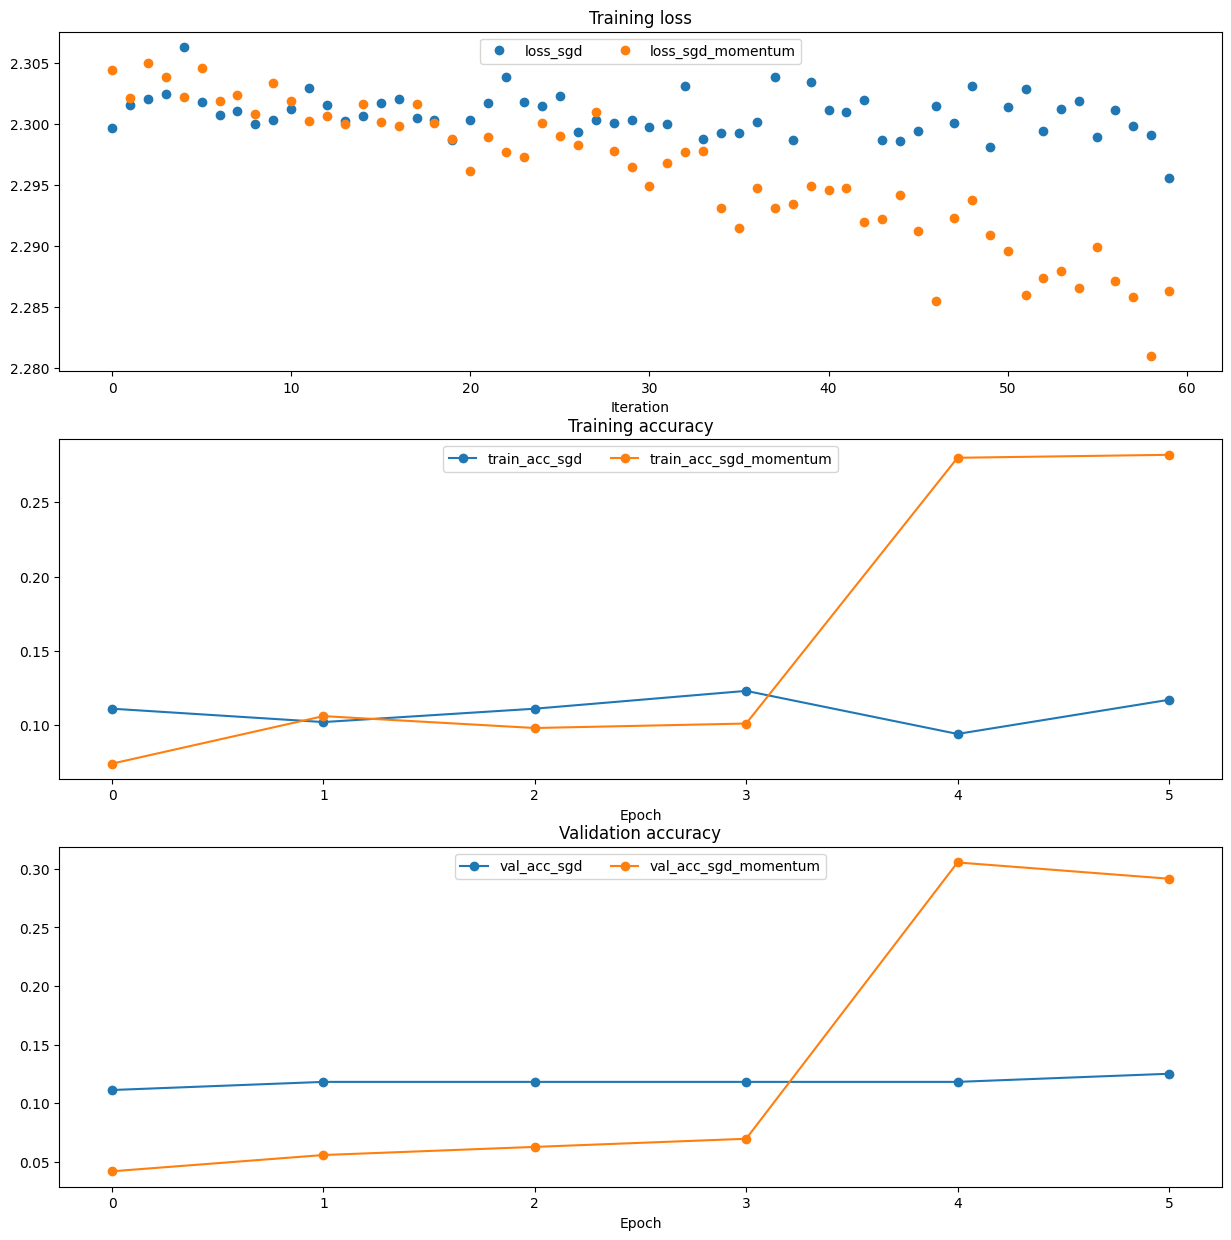

In [83]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], input_dim=8*8, weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

    plt.subplot(3, 1, 3)

    plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

Реализуйте алгоритмы RMSProp [1] and Adam [2] с коррекцией смещения  - методы rmsprop и adam . 


[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [84]:
# Test RMSProp implementation
from scripts.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [85]:
# Test Adam implementation
from scripts.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Обучите пару глубоких сетей с испольованием RMSProp и Adam алгоритмов обновления весов и сравните результаты обучения.

Получите лучшую полносвязную сеть для классификации вашего набора данных. На наборе CIFAR-10 необходимо получить accuracy не ниже 50 % на валидационном наборе.

In [86]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rate = 3.113669e-04 
weight_scale = 2.461858e-02
model = FullyConnectedNet([100, 100, 100, 100], weight_scale=weight_scale, input_dim=8*8, dtype=np.float64)

solver = Solver(model, data, print_every=100, num_epochs=15, batch_size=250, update_rule='adam',
                optim_config={'learning_rate': learning_rate})
solver.train()

best_model = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 75) loss: 2.302532
(Epoch 0 / 15) train acc: 0.127000; val_acc: 0.125000
(Epoch 1 / 15) train acc: 0.218000; val_acc: 0.173611
(Epoch 2 / 15) train acc: 0.304000; val_acc: 0.298611
(Epoch 3 / 15) train acc: 0.393000; val_acc: 0.402778
(Epoch 4 / 15) train acc: 0.311000; val_acc: 0.305556
(Epoch 5 / 15) train acc: 0.337000; val_acc: 0.333333
(Epoch 6 / 15) train acc: 0.323000; val_acc: 0.236111
(Epoch 7 / 15) train acc: 0.369000; val_acc: 0.284722
(Epoch 8 / 15) train acc: 0.487000; val_acc: 0.437500
(Epoch 9 / 15) train acc: 0.602000; val_acc: 0.631944
(Epoch 10 / 15) train acc: 0.576000; val_acc: 0.583333
(Epoch 11 / 15) train acc: 0.627000; val_acc: 0.527778
(Epoch 12 / 15) train acc: 0.684000; val_acc: 0.687500
(Epoch 13 / 15) train acc: 0.737000; val_acc: 0.715278
(Epoch 14 / 15) train acc: 0.754000; val_acc: 0.729167
(Epoch 15 / 15) train acc: 0.776000; val_acc: 0.743056


Получите оценку accuracy для валидационной и тестовой выборок. 

In [87]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.7430555555555556
Test set accuracy:  0.7611111111111111


# Нормализация по мини-батчам

Идея нормализации по мини-батчам предложена в работе [1]

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", ICML 2015.

Реализуйте прямой проход для слоя батч-нормализации - функция batchnorm_forward в scripts/layers.py . Проверьте свою реализацию, запустив следующий код:

In [88]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [7.32747196e-17 7.82707232e-17 1.03389519e-17]
  stds:   [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



In [89]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:   [1.01531427 1.01238373 0.97819987]



Реализуйте обратный проход в функции batchnorm_backward.

In [90]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.7029258328157158e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


Измените реализацию класса FullyConnectedNet, добавив батч-нормализацию. 
Если флаг normalization == "batchnorm", то вам необходимо вставить слой батч-нормализации перед каждым слоем активации ReLU, кроме выхода сети. 

In [91]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C, reg=reg, weight_scale=5e-2, dtype=np.float64, 
                              normalization='batchnorm')

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    
    if reg == 0: 
        print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 4.05e-10
b1 relative error: 2.22e-07
b2 relative error: 2.22e-08
b3 relative error: 1.01e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 6.96e-09
gamma2 relative error: 1.96e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 1.38e-08
b2 relative error: 7.99e-07
b3 relative error: 1.73e-10
beta1 relative error: 6.65e-09
beta2 relative error: 3.48e-09
gamma1 relative error: 8.80e-09
gamma2 relative error: 5.28e-09


Обучите 6-ти слойную сеть на наборе из 1000 изображений с батч-нормализацией и без нее

In [93]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, input_dim=8*8, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, input_dim=8*8, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.323302
(Epoch 0 / 10) train acc: 0.105000; val_acc: 0.062500
(Epoch 1 / 10) train acc: 0.887000; val_acc: 0.902778
(Iteration 21 / 200) loss: 0.873145
(Epoch 2 / 10) train acc: 0.926000; val_acc: 0.930556
(Iteration 41 / 200) loss: 0.414523
(Epoch 3 / 10) train acc: 0.986000; val_acc: 0.986111
(Iteration 61 / 200) loss: 0.104654
(Epoch 4 / 10) train acc: 0.993000; val_acc: 0.986111
(Iteration 81 / 200) loss: 0.119847
(Epoch 5 / 10) train acc: 0.998000; val_acc: 0.993056
(Iteration 101 / 200) loss: 0.086071
(Epoch 6 / 10) train acc: 0.998000; val_acc: 0.972222
(Iteration 121 / 200) loss: 0.148309
(Epoch 7 / 10) train acc: 0.999000; val_acc: 0.986111
(Iteration 141 / 200) loss: 0.033949
(Epoch 8 / 10) train acc: 0.997000; val_acc: 0.986111
(Iteration 161 / 200) loss: 0.026345
(Epoch 9 / 10) train acc: 0.998000; val_acc: 0.986111
(Iteration 181 / 200) loss: 0.026124
(Epoch 10 / 10) train acc: 0.997000; val_acc: 0.986111

Solver without b

Визуализируйте процесс обучения для двух сетей. Увеличилась ли скорость сходимости в случае с батч-нормализацией? Сделайте выводы. 

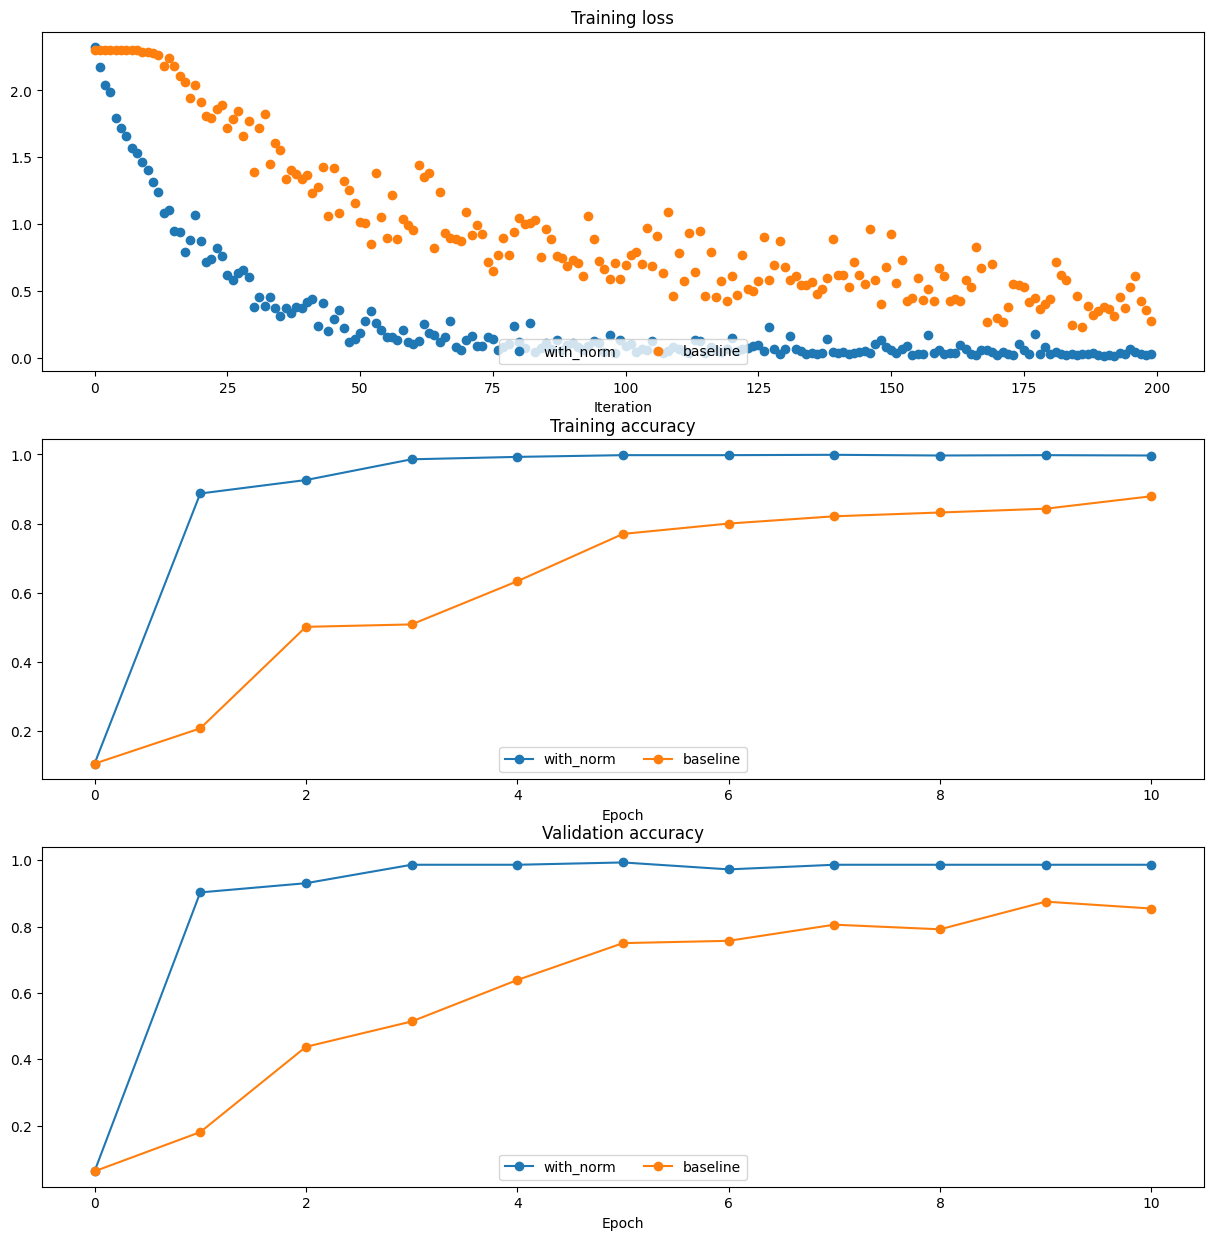

In [94]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

Использование нормализации позволяет ускорить процесс схождения нейронных сетей

Обучите 6-тислойную сеть с батч-нормализацией и без нее, используя разные размеры батча. Визуализируйте графики обучения. Сделайте выводы по результатам эксперимента. 

In [95]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Try training a very deep net with batchnorm
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims,input_dim=8*8, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims,input_dim=8*8, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


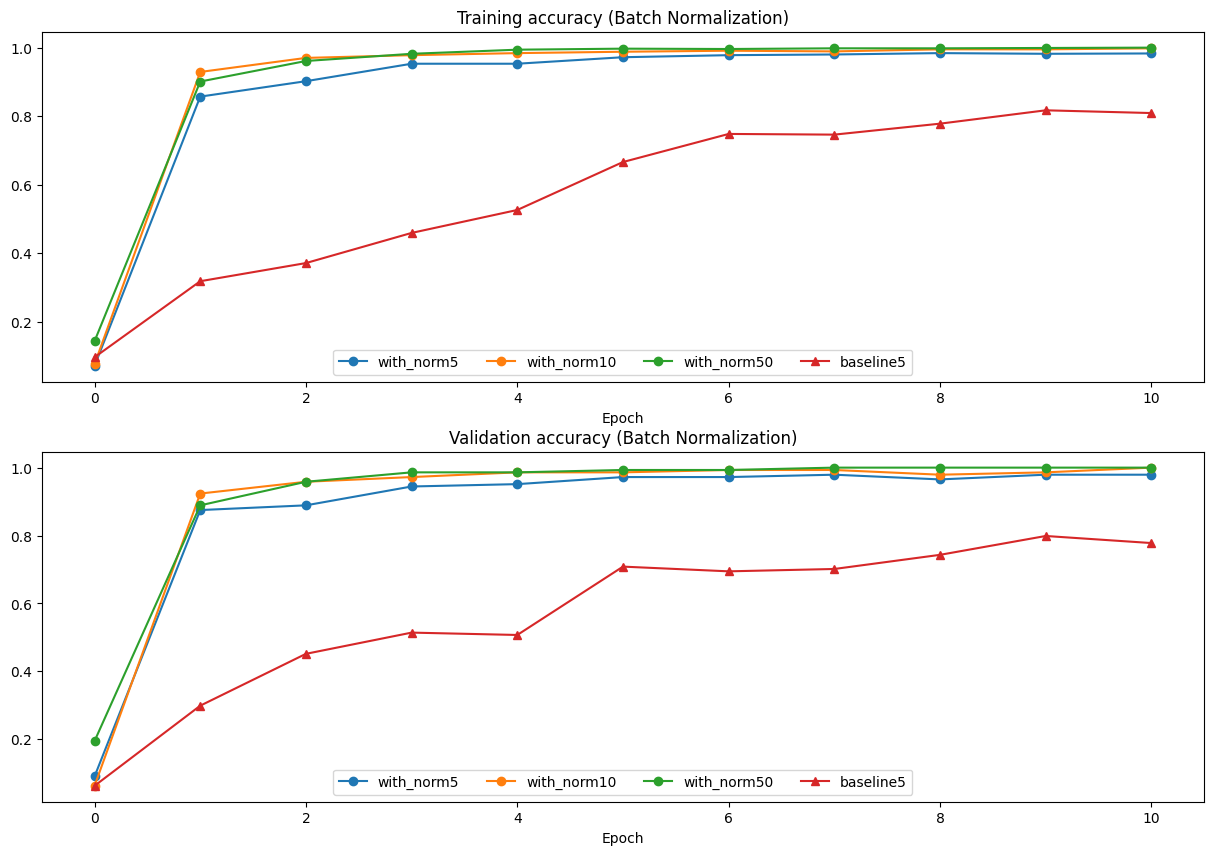

In [96]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

Так как большие батчи обычно дают более точные оценки градиентов и, следовательно, улучшают процесс обучения, мы видим, что точность на обучающем наборе растет при увеличении размера батча для обеих конфигураций сети

# Dropout

Реализуйте прямой проход для dropout-слоя в scripts/layers.py

http://cs231n.github.io/neural-networks-2/#reg

In [97]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



Реализуйте обратный проход для dropout-слоя

In [98]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


Добавьте в реализацию класса FullyConnectedNet поддержку dropout. Если параметр dropout != 1, то добавьте в модель dropout-слой после каждого слоя активации. Проверьте свою реализацию

In [99]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C, weight_scale=5e-2, dtype=np.float64, dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
    
    # Relative errors should be around e-6 or less; Note that it's fine
    # if for dropout=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



Обучите две двухслойные сети с dropout-слоем (вероятность отсева 0,25) и без на наборе из 500 изображений. Визуализируйте графики обучения. Сделайте выводы по результатам эксперимента

In [100]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
    model = FullyConnectedNet([500],input_dim=8*8, dropout=dropout)
    print(dropout)
    solver = Solver(model, small_data, num_epochs=25, batch_size=100, update_rule='adam',
                  optim_config={'learning_rate': 5e-4}, verbose=True, print_every=100)
    
    solver.train()
    solvers[dropout] = solver
    print()

1
(Iteration 1 / 125) loss: 2.301537
(Epoch 0 / 25) train acc: 0.266000; val_acc: 0.256944
(Epoch 1 / 25) train acc: 0.660000; val_acc: 0.659722
(Epoch 2 / 25) train acc: 0.814000; val_acc: 0.763889
(Epoch 3 / 25) train acc: 0.902000; val_acc: 0.888889
(Epoch 4 / 25) train acc: 0.892000; val_acc: 0.868056
(Epoch 5 / 25) train acc: 0.928000; val_acc: 0.902778
(Epoch 6 / 25) train acc: 0.938000; val_acc: 0.930556
(Epoch 7 / 25) train acc: 0.940000; val_acc: 0.909722
(Epoch 8 / 25) train acc: 0.954000; val_acc: 0.930556
(Epoch 9 / 25) train acc: 0.952000; val_acc: 0.937500
(Epoch 10 / 25) train acc: 0.966000; val_acc: 0.951389
(Epoch 11 / 25) train acc: 0.976000; val_acc: 0.944444
(Epoch 12 / 25) train acc: 0.966000; val_acc: 0.958333
(Epoch 13 / 25) train acc: 0.972000; val_acc: 0.944444
(Epoch 14 / 25) train acc: 0.970000; val_acc: 0.965278
(Epoch 15 / 25) train acc: 0.974000; val_acc: 0.958333
(Epoch 16 / 25) train acc: 0.970000; val_acc: 0.951389
(Epoch 17 / 25) train acc: 0.972000; v

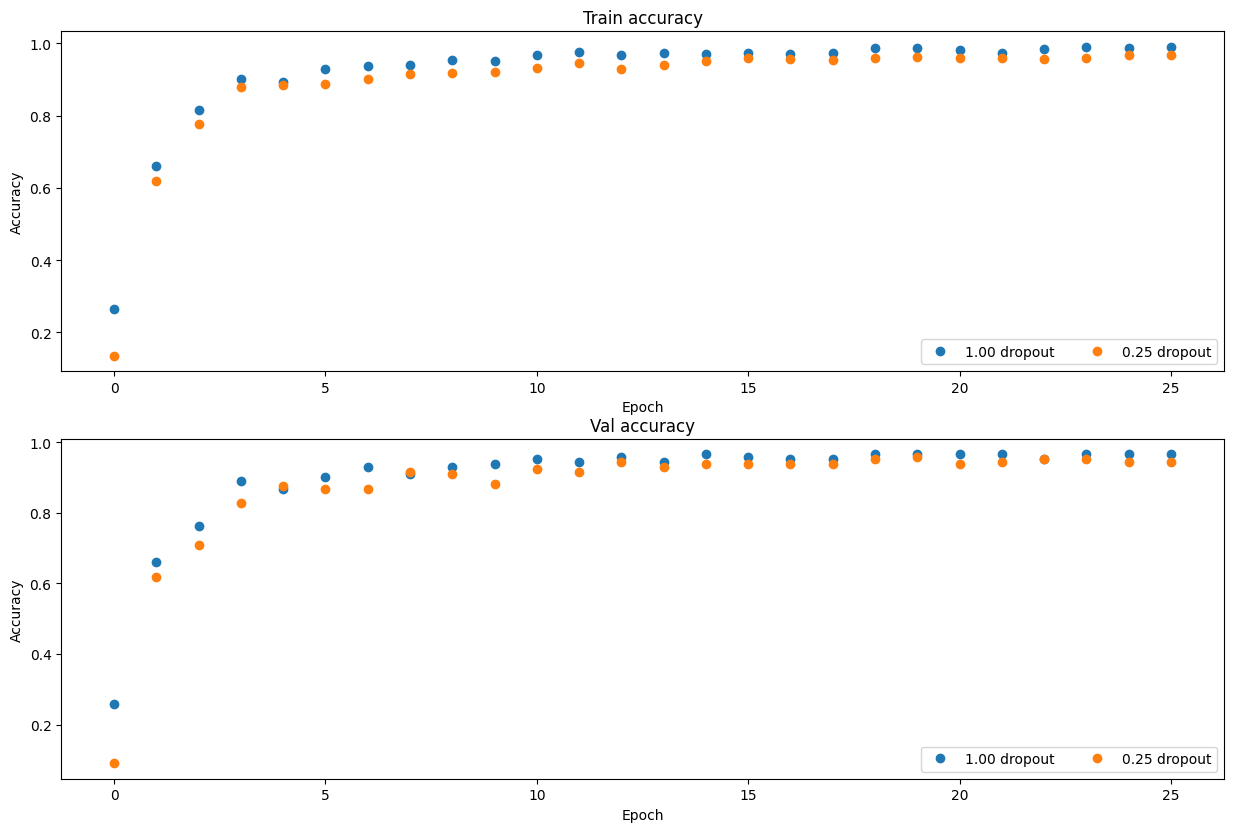

In [101]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

Можно заметить, что на обеих выборках модели ведут себя одинаково при любом dropout

# Сверточные нейронные сети (CNN)

Реализуйте прямой проход для сверточного слоя - функция conv_forward_naive в scripts/layers.py. Проверьте свою реализацию, запустив код ниже 

In [103]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


Реализуйте обратный проход - функция conv_backward_naive в scripts/layers.py

In [104]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471264748452487e-10
db error:  3.3726153958780465e-11


Реализуйте прямой проход для max-pooling слоя -функция  max_pool_forward_naive в scripts/layers.py

In [105]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


Реализуйте обратный проход для max-pooling слоя в max_pool_backward_naive . 

In [106]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


В скрипте scripts/fast_layers.py представлены быстрые реализации слоев свертки и пуллинга, написанных с использованием  Cython. 

Для компиляции выполните следующую команду в директории scripts

```bash
python setup.py build_ext --inplace
```


In [ ]:
!pip install Cython

Сравните ваши реализации слоев свертки и пуллинга с быстрыми реализациями.

In [107]:
# Rel errors should be around e-9 or less
from scripts.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 6.366910s
Fast: 0.012011s
Speedup: 530.098200x
Difference:  4.926407851494105e-11

Testing conv_backward_fast:
Naive: 8.787253s
Fast: 0.013001s
Speedup: 675.879958x
dx difference:  1.949764775345631e-11
dw difference:  4.957046344783224e-13
db difference:  4.102931673316555e-15


In [108]:
# Relative errors should be close to 0.0
from scripts.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.168523s
fast: 0.006995s
speedup: 24.091241x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.378023s
fast: 0.048029s
speedup: 7.870658x
dx difference:  0.0


В layer_utils.py вы можете найти  часто используемые комбинации слоев, используемых в сверточных сетях. Ознакомьтесь с ними и запустите код ниже для проверки их работы

In [109]:
from scripts.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  9.591132621921372e-09
dw error:  5.802401370096438e-09
db error:  1.0146343411762047e-09


In [110]:
from scripts.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.5218619980349303e-09
dw error:  2.702022646099404e-10
db error:  1.451272393591721e-10


Напишите реализацию класса ThreeLayerConvNet в scripts/classifiers/cnn.py . Вы можете использовать готовые реализации слоев и их комбинаций.

Проверьте вашу реализацию. Ожидается, что значение функции потерь softmax будет порядка `log(C)` для `C` классов для случая без регуляризации. В случае регуляризации значение функции потерь должно немного возрасти. 

In [111]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302586071243987
Initial loss (with regularization):  2.508255638232932


Проверьте реализацию обратного прохода

In [112]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


Попробуйте добиться эффекта переобучения. Обучите модель на небольшом наборе данных. Сравните значения accuracy на обучающих данных и на валидационных. Визуализируйте графики обучения 

In [124]:
num_train = 100
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
    'X_test': data['X_test'][:num_train],
    'y_test': data['X_test'][:num_train],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.301520
(Epoch 0 / 15) train acc: 0.340000; val_acc: 0.277778
(Iteration 2 / 30) loss: 2.552302
(Epoch 1 / 15) train acc: 0.190000; val_acc: 0.118056
(Iteration 3 / 30) loss: 2.292987
(Iteration 4 / 30) loss: 2.298941
(Epoch 2 / 15) train acc: 0.190000; val_acc: 0.083333
(Iteration 5 / 30) loss: 2.282326
(Iteration 6 / 30) loss: 2.262264
(Epoch 3 / 15) train acc: 0.190000; val_acc: 0.083333
(Iteration 7 / 30) loss: 2.254702
(Iteration 8 / 30) loss: 2.068167
(Epoch 4 / 15) train acc: 0.440000; val_acc: 0.326389
(Iteration 9 / 30) loss: 1.758068
(Iteration 10 / 30) loss: 1.554835
(Epoch 5 / 15) train acc: 0.430000; val_acc: 0.298611
(Iteration 11 / 30) loss: 1.434342
(Iteration 12 / 30) loss: 1.377478
(Epoch 6 / 15) train acc: 0.630000; val_acc: 0.562500
(Iteration 13 / 30) loss: 0.922358
(Iteration 14 / 30) loss: 1.429078
(Epoch 7 / 15) train acc: 0.790000; val_acc: 0.645833
(Iteration 15 / 30) loss: 0.650952
(Iteration 16 / 30) loss: 1.025912
(Epoch 8 / 15) tr

In [125]:
# Print final training accuracy
print("Small data training accuracy:", solver.check_accuracy(small_data['X_train'], small_data['y_train']))

Small data training accuracy: 0.96


In [126]:
# Print final validation accuracy
print("Small data validation accuracy:", solver.check_accuracy(small_data['X_val'], small_data['y_val']))

Small data validation accuracy: 0.8680555555555556


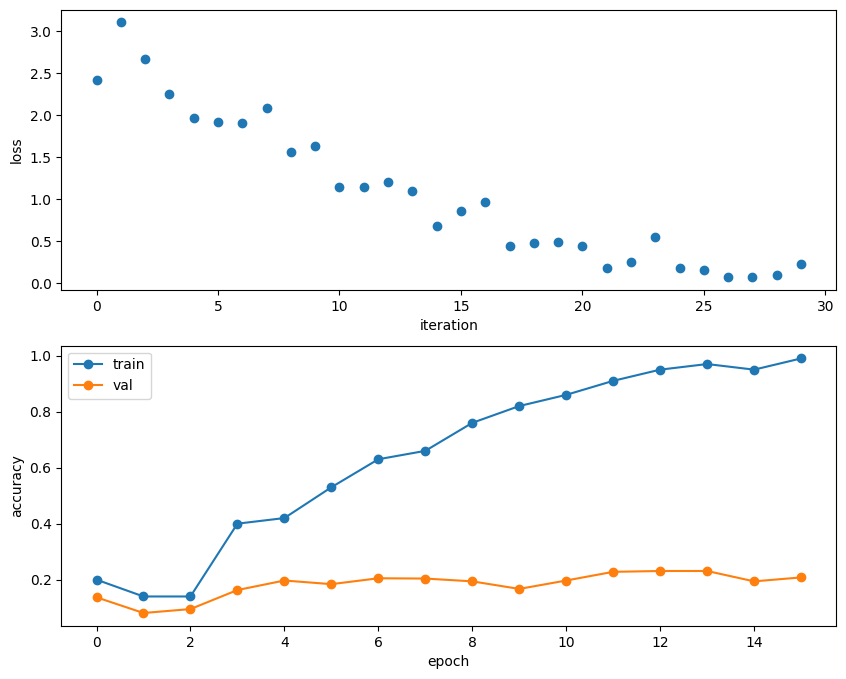

In [67]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Обучите сеть на полном наборе данных. Выведите accuracy на обучающей и валидационной выборках

In [127]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data, num_epochs=1, batch_size=50, update_rule='adam',
                optim_config={'learning_rate': 1e-3}, verbose=True, print_every=20)
solver.train()

(Iteration 1 / 25) loss: 2.302718
(Epoch 0 / 1) train acc: 0.090000; val_acc: 0.055556
(Iteration 21 / 25) loss: 1.263459
(Epoch 1 / 1) train acc: 0.718000; val_acc: 0.708333


In [69]:
# Print final training accuracy
print("Full data training accuracy:", solver.check_accuracy(small_data['X_train'], small_data['y_train']))

Full data training accuracy: 0.51


In [128]:
# Print final validation accuracy
print("Full data validation accuracy:", solver.check_accuracy(data['X_val'], data['y_val']))

Full data validation accuracy: 0.7083333333333334


Визуализируйте фильтры на первом слое обученной сети

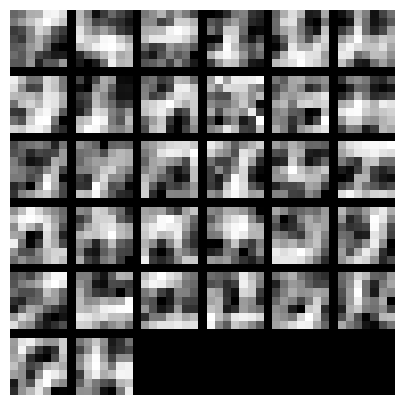

In [129]:
from scripts.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()